<a href="https://colab.research.google.com/github/ksamcaN8/PGS_AdmixAncestry/blob/main/IBD_choosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
"""
import math
import random
from numpy.ma.core import zeros
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import normaltest
from statistics import mean
from operator import index
"""

'\nimport math\nimport random\nfrom numpy.ma.core import zeros\nfrom scipy.stats.stats import pearsonr\nfrom scipy.stats import ttest_ind\nfrom scipy.stats import shapiro\nfrom scipy.stats import normaltest\nfrom statistics import mean\nfrom operator import index\n'

In [ ]:
geneticMap=pd.read_csv('/content/genetic_map_hg38.txt',sep='\t',names=['chr','position','COMBINED_rate(cM/Mb)','Genetic_Map(cM)'])
chr_len=pd.DataFrame(index=range(1,23),columns=['chr','len'])
for i in range(1,23):
  #print(i,int(geneticMap[geneticMap['chr']=='chr'+str(i)].tail(1)['position'])-int(geneticMap[geneticMap['chr']=='chr'+str(i)].head(1)['position']))
  chr_len.loc[i,'chr']='chr'+str(i)
  chr_len.loc[i,'len']=int(geneticMap[geneticMap['chr']=='chr'+str(i)].tail(1)['position'])-int(geneticMap[geneticMap['chr']=='chr'+str(i)].head(1)['position'])
overall_length=sum(chr_len['len'])
overall_length
#chr_len

In [2]:
#geneticMap
overall_length=2788731141

In [3]:
IBDfile=pd.read_csv('/content/pedsim_mix_YRIandCUE.seg',sep='\t',names=['sample_1','sample_2','chromosome','physical_position_start','physical_position_end','IBD_type','genetic_position_start','genetic_position_end','genetic_length'])
IBDfile['physical_length']=IBDfile['physical_position_end']-IBDfile['physical_position_start']
for i in range(0,len(IBDfile.index)):
  IBDfile.loc[i,'generation_sample1']=str(IBDfile.loc[i,'sample_1']).split('_')[1]
  IBDfile.loc[i,'generation_sample2']=str(IBDfile.loc[i,'sample_2']).split('_')[1].split('-')[0]
IBDfile=IBDfile[(IBDfile['generation_sample1']=='g1-b1-s1')&(IBDfile['generation_sample2']=='g3')]

In [4]:
# for every 2 samples: sum all the IBD lengths (times 2 if it's IBD2 ??), and devide by genome length
IBD_scores=pd.DataFrame(IBDfile.query('IBD_type=="IBD1"').groupby(['sample_1','sample_2'])['physical_length'].sum()/(2*overall_length))
IBD_scores=pd.concat([IBD_scores,pd.DataFrame(IBDfile.query('IBD_type=="IBD2"').groupby(['sample_1','sample_2'])['physical_length'].sum()/(overall_length))])
IBD_scores['chosen_IBD']=np.zeros(len(IBD_scores.index))
IBD_scores.sort_index(inplace=True)
for i in range(len(IBD_scores.index)//4):
  IBD_scores['chosen_IBD'][i*4+np.argmax(IBD_scores[i*4:i*4+4]['physical_length'])]=1
IBD_scores.reset_index(inplace=True)
IBD_scores.set_index('sample_2',inplace=True)
IBD_scores

,sample_1,physical_length,chosen_IBD
sample_2,,,
mixedSamples10_g3-b1-i1,mixedSamples10_g1-b1-s1,0.274853,0.0
mixedSamples10_g3-b1-i2,mixedSamples10_g1-b1-s1,0.390572,1.0
mixedSamples10_g3-b1-i3,mixedSamples10_g1-b1-s1,0.368179,0.0
mixedSamples10_g3-b1-i4,mixedSamples10_g1-b1-s1,0.253220,0.0
mixedSamples11_g3-b1-i1,mixedSamples11_g1-b1-s1,0.208403,0.0
...,...,...,...
mixedSamples8_g3-b1-i4,mixedSamples8_g1-b1-s1,0.208837,0.0
mixedSamples9_g3-b1-i1,mixedSamples9_g1-b1-s1,0.314979,1.0
mixedSamples9_g3-b1-i2,mixedSamples9_g1-b1-s1,0.205579,0.0


In [5]:
print('min',IBD_scores['physical_length'].min())
print('mean',IBD_scores['physical_length'].mean())
print('meadian',IBD_scores['physical_length'].median())
print('max',IBD_scores['physical_length'].max())
print('std',IBD_scores['physical_length'].std())

min 0.11203530842631344
mean 0.2520267988576634
meadian 0.2536324317360933
max 0.44480208857824777
std 0.05375306650674632


Text(0.35, 12, 'mean of selected= 0.31')

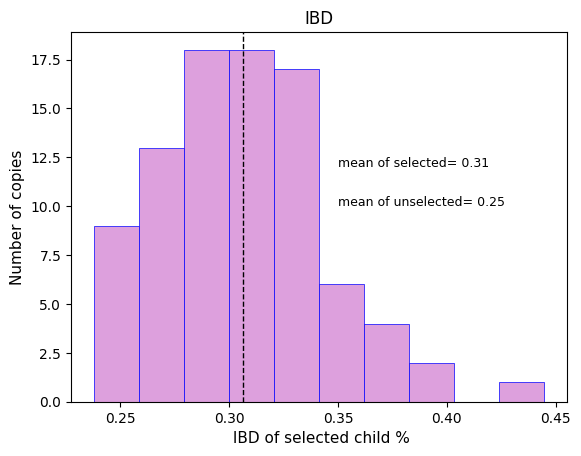

In [12]:
plt.title('IBD')
plt.xlabel(' IBD of selected child %',fontsize=11)
plt.ylabel('Number of copies',fontsize=11)
plt.hist(IBD_scores.query('chosen_IBD==1')['physical_length'],color = "plum", ec="blue",lw=0.5,label='IBD')
plt.axvline(np.mean(IBD_scores.query('chosen_IBD==1')['physical_length']), color='black',linestyle='dashed', linewidth=1)
plt.text(0.35,10,'mean of unselected= '+str(round(IBD_scores['physical_length'].mean(),2)),fontsize=9)
plt.text(0.35,12,'mean of selected= '+str(round(np.mean(IBD_scores.query('chosen_IBD==1')['physical_length']),2)),fontsize=9)

In [10]:
admix=pd.read_csv("/content/1trimmed_YRIandCUEand_pedsim_mix_YRIandCUE.2.Q",sep='\s',names=['CUE','YRI']) # ,names=['YRI','CUE']) # ?? - what is the right order??
admix=pd.concat([pd.read_csv("/content/1samples_YRIandCUEand_pedsim_mix_YRIandCUE.txt",names=['IID']),admix], axis="columns")
admix.set_index('IID',inplace=True)
for c in admix.columns:
  if c !='IID':
    admix=admix.astype({c:float})
my_scores=pd.merge(IBD_scores,admix,left_index=True,right_index=True,how='inner')

my_scores['CUE']=round(my_scores['CUE']*100,4)
#parent_CUE_means=my_scores.groupby(['Family','Generation']).mean().query('Generation==2')['CUE']

<ipython-input-10-fc956a9c5f30>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  admix=pd.read_csv("/content/1trimmed_YRIandCUEand_pedsim_mix_YRIandCUE.2.Q",sep='\s',names=['CUE','YRI']) # ,names=['YRI','CUE']) # ?? - what is the right order??


In [14]:
my_scores

,sample_1,physical_length,chosen_IBD,CUE,YRI
mixedSamples10_g3-b1-i1,mixedSamples10_g1-b1-s1,0.274853,0.0,0.0010,0.999990
mixedSamples10_g3-b1-i2,mixedSamples10_g1-b1-s1,0.390572,1.0,0.0010,0.999990
mixedSamples10_g3-b1-i3,mixedSamples10_g1-b1-s1,0.368179,0.0,0.0010,0.999990
mixedSamples10_g3-b1-i4,mixedSamples10_g1-b1-s1,0.253220,0.0,0.0010,0.999990
mixedSamples11_g3-b1-i1,mixedSamples11_g1-b1-s1,0.208403,0.0,18.8153,0.811847
...,...,...,...,...,...
mixedSamples8_g3-b1-i4,mixedSamples8_g1-b1-s1,0.208837,0.0,41.0279,0.589721
mixedSamples9_g3-b1-i1,mixedSamples9_g1-b1-s1,0.314979,1.0,55.1747,0.448253
mixedSamples9_g3-b1-i2,mixedSamples9_g1-b1-s1,0.205579,0.0,47.2963,0.527037
mixedSamples9_g3-b1-i3,mixedSamples9_g1-b1-s1,0.257478,0.0,47.8592,0.521408


In [ ]:
my_scores
print('IBD', ttest_1samp(my_scores.query('chosen_IBD==1')['CUE'],0)[1]) #-np.array(parent_CUE_means),0)[1])

IBD 1.532349561216588e-17


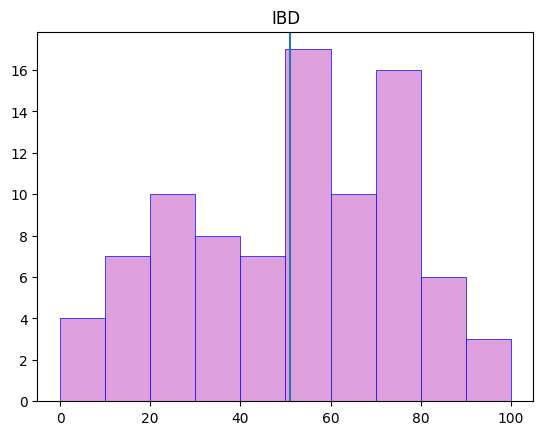

In [16]:
plt.title('IBD')
plt.hist(my_scores.query('chosen_IBD==1')['CUE'],color = "plum", ec="blue",lw=0.5,label='IBD')#-np.array(parent_CUE_means),color = "plum", ec="blue",lw=0.5,bins=np.arange(-13,13,1),label='IBD')
#plt.axvline(0, color='black',linestyle='dashed', linewidth=1)
plt.axvline(np.mean(my_scores.query('chosen_IBD==1')['CUE']))#-np.array(parent_CUE_means)), color='black',linestyle='dashed', linewidth=1)
#plt.text(-13,12,'mean= '+str(round(np.mean(my_scores.query('chosen_IBD==1')['CUE']),2))+ '%', fontsize = 9)#-np.array(parent_CUE_means)),2))+ '%', fontsize = 9)
#plt.text(-10,10,'P= '+'9e-17',fontsize = 9)